In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import missingno
import seaborn as sns
import pandas_profiling 
import datetime as dt
from scipy import stats as sps
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
from matplotlib.dates import date2num, num2date
from matplotlib import ticker

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# R_t MODEL FROM: https://github.com/rtcovidlive/rtlive-global/blob/master/notebooks/Tutorial_model.ipynb

### Precalculated data for 50 states can be found in /data/rt.csv

In [4]:
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

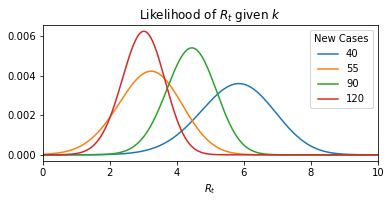

In [5]:
k = np.array([20, 40, 55, 90,120])
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)
# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');


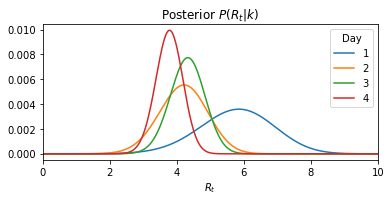

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
4    3.78
dtype: float64

In [8]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])
hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12
4,3.10,4.42


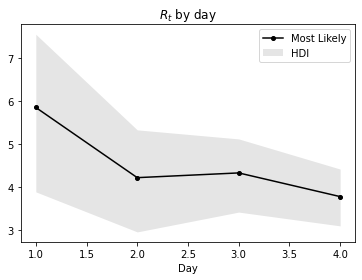

In [9]:


ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();



In [10]:
alabama = pd.read_csv('data/3_covidtracking/alabama-history.csv',
                     usecols=['date', 'positive'],
                     parse_dates=['date'],
                     index_col=[ 'date'],
                     squeeze=True).sort_index()
alabama

date
2020-03-07         0
2020-03-08         0
2020-03-09         0
2020-03-10         0
2020-03-11         0
               ...  
2021-01-02    369458
2021-01-03    371934
2021-01-04    374095
2021-01-05    379593
2021-01-06    384184
Name: positive, Length: 306, dtype: int64

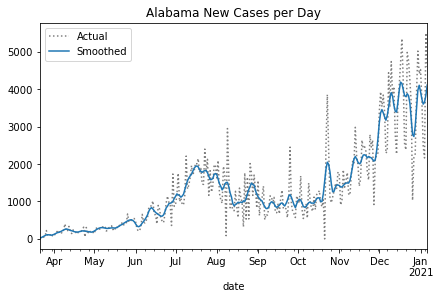

In [11]:
state_name = 'Alabama'

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = alabama

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [12]:
smoothed

date
2020-03-21      25.0
2020-03-22      31.0
2020-03-23      49.0
2020-03-24      69.0
2020-03-25      89.0
               ...  
2021-01-02    3735.0
2021-01-03    3599.0
2021-01-04    3649.0
2021-01-05    3832.0
2021-01-06    4108.0
Name: positive, Length: 292, dtype: float64

In [13]:
def get_posteriors(sr, sigma=0.15):

    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])

    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    process_matrix /= process_matrix.sum(axis=0)
    
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.10)

In [14]:
posteriors

date,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,...,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06
0.00,0.000833,4.002497e-04,7.416151e-07,1.278650e-09,7.282148e-12,2.154333e-13,1.561631e-12,2.942956e-11,5.488833e-10,5.559011e-09,...,6.256211e-32,9.276916e-70,1.462982e-92,1.325747e-65,2.823164e-33,9.436814e-21,1.572924e-18,5.090159e-27,8.125786e-41,5.602962e-56
0.01,0.000833,4.317102e-04,8.241348e-07,1.449584e-09,8.415207e-12,2.542060e-13,1.858959e-12,3.524064e-11,6.571981e-10,6.633897e-09,...,2.037117e-31,5.841745e-69,1.372939e-91,9.374711e-65,1.124993e-32,2.705380e-20,4.151384e-18,1.661711e-26,3.582889e-40,3.331853e-55
0.02,0.000833,4.626646e-04,9.103256e-07,1.634778e-09,9.683284e-12,2.990462e-13,2.208844e-12,4.213919e-11,7.857682e-10,7.904068e-09,...,6.568350e-31,3.640423e-68,1.273752e-90,6.546116e-64,4.424927e-32,7.657603e-20,1.082253e-17,5.360131e-26,1.560910e-39,1.956921e-54
0.03,0.000833,4.927929e-04,9.997288e-07,1.834512e-09,1.109869e-11,3.508461e-13,2.620545e-12,5.032858e-11,9.383523e-10,9.404466e-09,...,2.097127e-30,2.245059e-67,1.168248e-89,4.513705e-63,1.717907e-31,2.140004e-19,2.786831e-17,1.708389e-25,6.718847e-39,1.135209e-53
0.04,0.000833,5.218020e-04,1.091863e-06,2.049059e-09,1.267512e-11,4.106419e-13,3.105033e-12,6.005101e-11,1.119412e-09,1.117631e-08,...,6.630011e-30,1.370145e-66,1.059248e-88,3.073275e-62,6.583031e-31,5.904576e-19,7.088167e-17,5.380031e-25,2.857455e-38,6.504113e-53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,0.000833,1.396039e-23,2.675235e-42,5.849329e-76,3.943862e-125,2.799617e-187,5.812446e-263,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.97,0.000833,1.176851e-23,2.044499e-42,3.603110e-76,1.786239e-125,8.881882e-188,1.255567e-263,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.98,0.000833,9.860558e-24,1.558524e-42,2.218333e-76,8.078066e-126,2.811930e-188,2.705103e-264,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11.99,0.000833,8.209538e-24,1.184724e-42,1.365057e-76,3.647758e-126,8.883742e-189,5.812848e-265,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


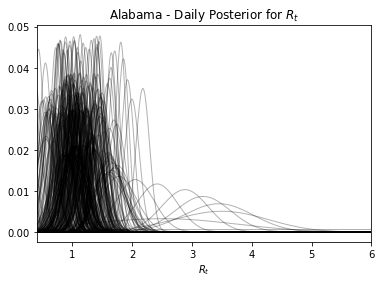

In [15]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [16]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)

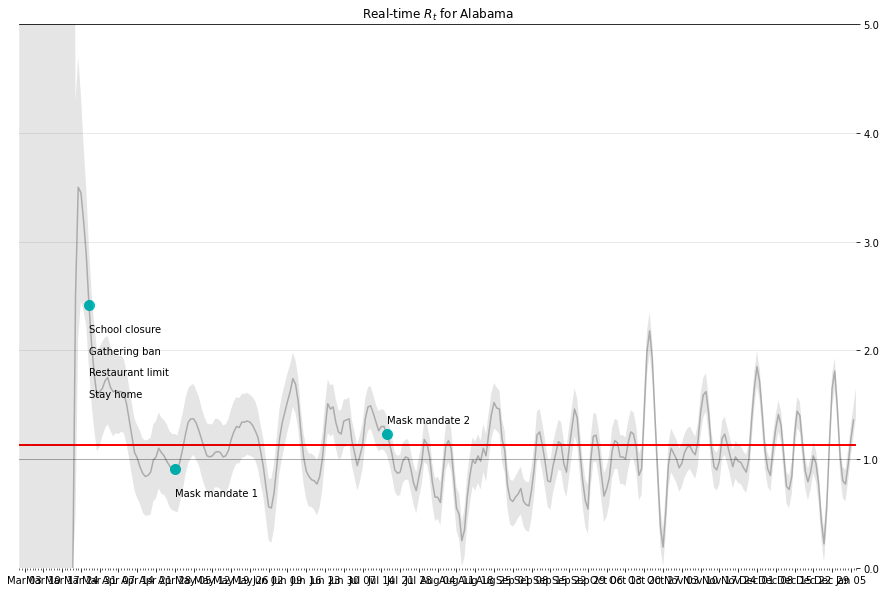

In [17]:
def plot_rt(result, ax, state_name='NY'):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
#     ax.scatter(index,
#                values,
#                s=40,
#                lw=.5,
# #                c=cmap(color_mapped(values)),
#                edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)

mask_date1 = pd.to_datetime('2020-04-28')
schools_close = pd.to_datetime('2020-03-27')
mask_date2 = pd.to_datetime('2020-07-16')

ax.plot(mask_date1, result.loc[mask_date1].ML, 'o', markersize = 10,color='c')
plt.annotate("Mask mandate 1",(mask_date1, result.loc[mask_date1].ML-0.25))

ax.plot(schools_close, result.loc[schools_close].ML, 'o', markersize = 10,color='c')
plt.annotate("School closure",(schools_close, result.loc[schools_close].ML-0.25))
plt.annotate("Gathering ban",(schools_close, result.loc[schools_close].ML-0.45))
plt.annotate("Restaurant limit",(schools_close, result.loc[schools_close].ML-0.65))
plt.annotate("Stay home",((schools_close, result.loc[schools_close].ML-0.85)))

ax.plot(mask_date2, result.loc[mask_date2].ML, 'o', markersize = 10,color='c')
plt.annotate("Mask mandate 2",(mask_date2, result.loc[mask_date2].ML+0.1))
figwidth = 15
fig.set_figwidth(figwidth) 
fig.set_figheight(figwidth*2/3) 

ax.axhline(y=result['ML'].mean(),linewidth=2, color='r')

ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [18]:
result

,ML,Low_90,High_90
date,,,
2020-03-21,0.00,0.00,10.81
2020-03-22,2.51,0.48,4.30
2020-03-23,3.50,2.11,4.70
2020-03-24,3.45,2.45,4.35
2020-03-25,3.19,2.36,3.88
...,...,...,...
2021-01-02,0.80,0.64,0.93
2021-01-03,0.77,0.61,0.90
2021-01-04,0.95,0.80,1.09
